# Visualizing multiple distributions at the same time

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

##  1.0 NYCFlights13 dataset

The [NYCFlights13 dataset](#https://cran.r-project.org/web/packages/nycflights13/nycflights13.pdf) dataset, which contains information on over 300,000 planes departing NYC airports in 2013. We will focus on visualizing the distribution of arrival delays given in minutes.

In [2]:
flights = pd.read_csv(os.path.join(os.getcwd(), 'input', 'flights.csv'))
carriers = pd.read_csv(os.path.join(os.getcwd(), 'input', 'carriers.csv'), index_col = 0)
airlines = pd.read_csv(os.path.join(os.getcwd(), 'input', 'airlines.csv'))

# Merge and get subset
flights = flights.merge(airlines, how = 'left', on = 'carrier')
flights = flights[['arr_delay', 'name']] 

# Upon iniital inspection - Filter flight delays between -60 and 120 minutes
flights = flights[flights['arr_delay'].between(-60, 120)]

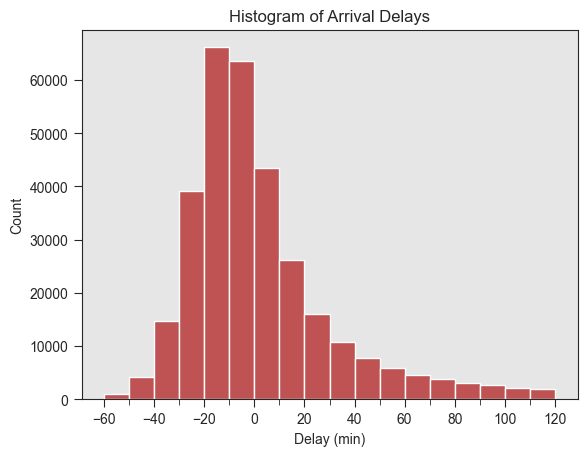

In [3]:
def style_axes(ax, xstart, xend, major_step, minor_step):
    ax.set_xticks(np.arange(xstart, xend+1, major_step), minor=False)
    ax.set_xticks(np.arange(xstart + minor_step, xend, minor_step), minor=True)
    ax.tick_params(axis='both', which = 'major', length = 6)
    ax.tick_params(axis='both', which = 'minor', length = 4)

bw = 10
sns.set_style("ticks", {"axes.facecolor": ".9"})
ax = sns.histplot( data = flights, x = "arr_delay", kde=False, 
                  binwidth = bw, color = 'firebrick', binrange = [-60, 120] )
ax.set_title('Histogram of Arrival Delays')
ax.set_xlabel("Delay (min)")
style_axes(ax, -60, 120, 20, 10)
plt.show()

## 2.0 Where Histograms Fail: Multiple Categories

Histograms work very well for displaying a single variable from one category (for example, arrivals delays). However, a histogram does not work well for displaying multiple categories because the plots are obscured.

In [4]:
# Extract top five airlines with most flights
carrier_flights = pd.Series(flights.groupby('name')['name'].count())
carrier_flights = carrier_flights.sort_values(ascending=False)
top_five = carrier_flights.index[:5]

# Subset to the top 5 airlines
top_five_flights = flights[flights['name'].isin(top_five)]

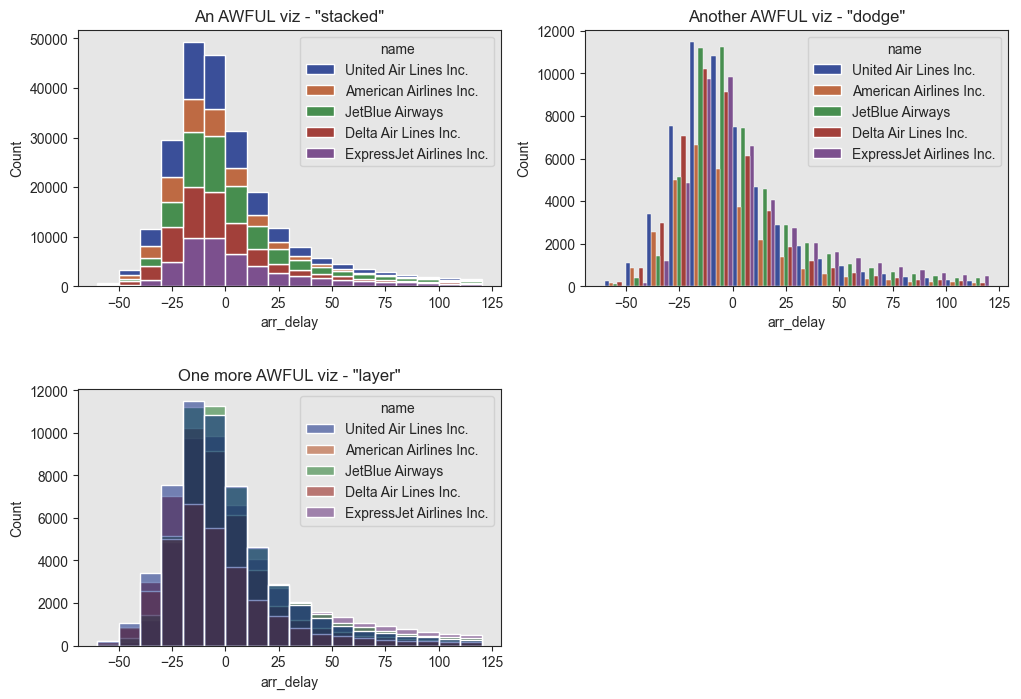

In [5]:
fig, ax = plt.subplots(2, 2, figsize = (12,8))
ax = ax.flatten()

def plot_hist(ax, method, title):
    
    ax = sns.histplot( data = top_five_flights, x = "arr_delay", kde=False, 
                      binwidth = bw, color = 'firebrick', binrange = [-60, 120], 
                      hue = 'name', multiple = method, palette = 'dark', ax = ax)
    ax.set_title(title)

plot_hist(ax[0], "stack", 'An AWFUL viz - "stacked"')
plot_hist(ax[1], "dodge", 'Another AWFUL viz - "dodge"')
plot_hist(ax[2], "layer", 'One more AWFUL viz - "layer"')
ax[3].set_axis_off()
plt.subplots_adjust(hspace = 0.4)

## 3.0 KDE plots are a viable option - But pay attention to scaling!

To visualize several distributions at once, kernel density plots will generally work better than histograms.

However, this will depend heavily on the dataset.

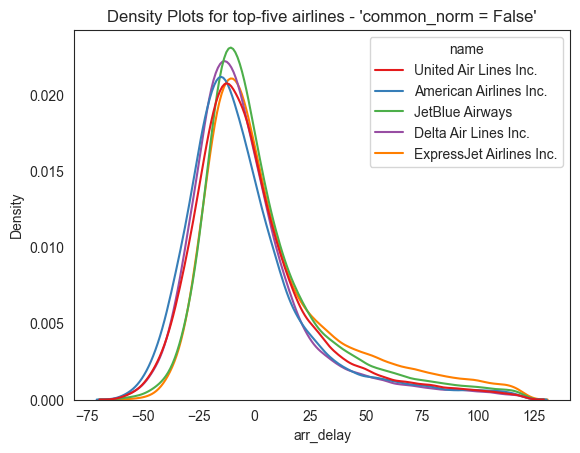

In [6]:
sns.set_style("white")
fig, ax = plt.subplots()
ax = sns.kdeplot(data = top_five_flights, x = "arr_delay", 
                 hue = 'name', palette = 'Set1', ax = ax, common_norm = False)
ax.set_title("Density Plots for top-five airlines - 'common_norm = False'");

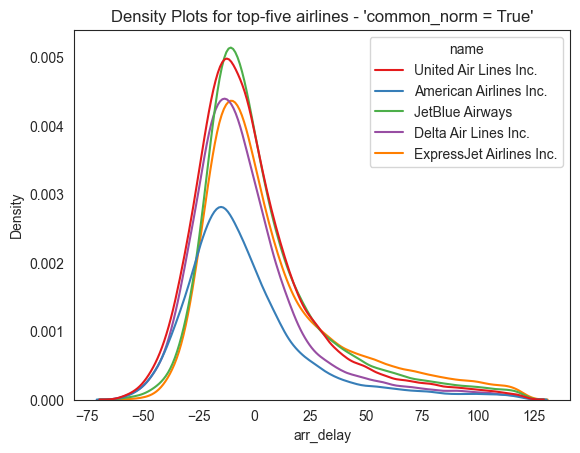

In [7]:
sns.set_style("white")
fig, ax = plt.subplots()
ax = sns.kdeplot(data = top_five_flights, x = "arr_delay", 
                 hue = 'name', palette = 'Set1', ax = ax, common_norm = True)
ax.set_title("Density Plots for top-five airlines - 'common_norm = True'");

## 4.0 KDEs not great here

### Perceptions of Probability and Numbers

The raw data comes from responses to the following question: 

*What* ***probability or number*** *would you assign to the phrase* ***phrase*** *?*

In [8]:
df = pd.read_csv(os.path.join(os.getcwd(), 'input', 'people_perception.csv'))
df = pd.melt(df, var_name='phrase', value_name='probability')
df.sample(5).reset_index(drop = True)

,phrase,probability
0,We Doubt,5.0
1,Highly Likely,80.0
2,Likely,85.0
3,We Believe,50.0
4,Chances Are Slight,20.0


Getting a subset of phrases and removing outliers.

In [9]:
columns_subset = ['Almost Certainly', 'Highly Likely', 'Probable', 'Likely','Very Good Chance', 
                 'We Believe',  'About Even', 'Unlikely', 'Probably Not']
df = df.loc[df['phrase'].isin(columns_subset)]

#  Upon inspection there was a clear outlier for 'Highly Likely'
idxmin = df.loc[df['phrase'] == 'Highly Likely', 'probability'].idxmin()
df.drop(idxmin, axis = 0, inplace = True)

#  Upon inspection there was a clear outlier for 'Probably Not' = 100 
idxmax = df.loc[df['phrase'] == 'Probably Not', 'probability'].idxmax()
df.drop(idxmax, axis = 0, inplace = True)

order = list(df.groupby('phrase').mean().sort_values(by='probability', ascending = False).index)

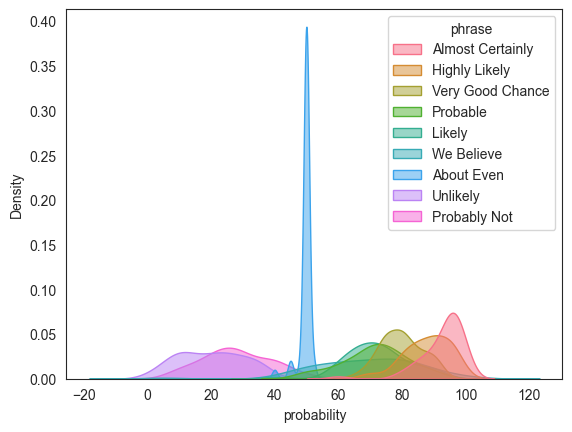

In [10]:
ax = sns.kdeplot(df, x = 'probability', hue = 'phrase', fill = True,
                    palette = sns.color_palette("husl", 9), common_norm = False,
                    alpha = 0.5)